In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

## Data loading

In [39]:
data = pd.read_csv("krankenkasse-mit-pbf.csv", sep = ";", names = ['age', 'sex', 'bmi', 'children', 'smoker', 'canton', "pbf", 'charges'])
data = data.iloc[1:]

data['charges'] = data['charges'].str.replace("’", "").apply(pd.to_numeric)
data['pbf'] = data['pbf'].apply(pd.to_numeric)
data['bmi'] = data['bmi'].apply(pd.to_numeric)
data['age'] = data['age'].apply(pd.to_numeric)
data['children'] = data['children'].apply(pd.to_numeric)

# Encode categorical variables.
data["sex"] = pd.factorize(data['sex'])[0]
data["smoker"] = pd.factorize(data['smoker'])[0]

data['canton'] = pd.factorize(data['canton'])[0]

# Remove encoded categorical variables.

# 1 record with negative percentage of body fat.
data = data[data["pbf"]>0]

# Divide the charges into categories. Is there a more objective way to determine the categories? K-clustering?
bins = [0, 5000, 10000, 20000, 100000]
bin_labels = [0, 1, 2, 3]
data["charges_level"] = pd.cut(data["charges"], bins=bins, labels=bin_labels, include_lowest=True)


data.sort_values(by='charges', ascending=False, na_position='first')
data = data.dropna()

### Data without outliers:

In [3]:
#index are not correct, don't know why, removed entries manually
children_outliers_to_del = data[(data['age'] <= 21) & (data['children'] == 5)].index.values - 1

for i in children_outliers_to_del:
    print(i)

#when these are removed, the score is worse by .10 for some reason but the mean absolute error drops by 60 points
data2 = data.drop(data.index[[32, 165, 983]])
data2[(data2['age'] <= 21) & (data2['children'] == 5)]

charges_outliers_to_del = data2[(data['charges'] >= 59000)].index.values - 1
for i in charges_outliers_to_del:
    print(i)

data_no_outliers = data2.drop(data.index[[542]])

data_no_outliers[(data['charges'] >= 59000)]
data_no_outliers

32
166
984
543


<ipython-input-3-06bfd6831598>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  charges_outliers_to_del = data2[(data['charges'] >= 59000)].index.values - 1
<ipython-input-3-06bfd6831598>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_no_outliers[(data['charges'] >= 59000)]


,age,sex,bmi,children,smoker,canton,pbf,charges,charges_level
1,19,0,24.720,0,0,0,35.94,4253,0
2,18,1,29.416,1,1,1,26.86,2494,0
3,28,1,28.800,3,1,1,26.92,3138,0
4,33,1,20.564,0,1,2,7.98,1553,0
5,32,1,25.504,0,1,2,21.84,2768,0
...,...,...,...,...,...,...,...,...,...
1334,50,1,27.176,3,1,2,23.02,5767,1
1335,18,0,27.936,0,1,3,42.18,2547,0
1336,18,0,31.880,0,1,1,49.59,3026,0
1337,21,0,23.040,0,1,0,31.18,2208,0


## Implementation of the ridge regression functions

In [4]:
from sklearn.base import BaseEstimator

class RidgeRegression(BaseEstimator):
    
    def __init__(self, opt_method='gd', alpha=1., eta=0.01, maxsteps=100, eps=0.00000001):
        '''Implements a Ridge Regression estimator.
        
        Arguments
        ---------
        alpha:      Regularization proportionality factor. Larger values
                    correspond with stronger regularization.
        opt_method: Optimization method to choose for the cost function.
                    Can be either 'gd' (Gradient Descent) or 'neq'.
        maxsteps:   Maximum number of Gradient Descent steps to take.
        eps:        Epsilon, length of gradient to be reached with Gradient
                    Descent.
        eta:        Fixed step lenght to take at each gradient descent
                    iteration.
        '''
        # parameters
        self.alpha = alpha
        self.opt_method = opt_method
        self.maxsteps = maxsteps
        self.eps = eps
        self.eta = eta
        # attributes
        # model coefficients
        self.beta_ = None
        # values of cost function along gradient descent iterations
        self.costs_ = []  
        self.bins = [0, 5000, 10000, 20000, 100000]
        
    def fit(self,X,y):
        if(self.opt_method == "neq"):
            type(X)
            return(self.normalequation(X,y))
        else:
            raise Exception("No available optimization method was chosen.")
            
    def normalequation(self,X,y):
        '''Computes the coefficients of the ridge regression cost function
        using the normalequation.
        '''
        
        XX = np.zeros((len(X),X.shape[1]+1))
        XX[:,0] = np.ones(len(X))

        XX[:,1:] = X
        
        #identity matrix with full range
        identity = np.identity(XX.shape[1])
        identity[0,:] = np.zeros(identity.shape[0])
        
        self.beta_ = np.linalg.inv(XX.T @ XX + self.alpha * identity) @ XX.T @ y
        
        return(self.beta_)
    
    @staticmethod 
    def costfunction(beta,X,y,alpha):
        '''Computes and returns the value of the ridge regression cost function.
        '''
        
        cost = np.sum((y - beta[0] + np.dot(X, beta[1:])**2) + alpha * np.sum(beta.T @ beta))
        
        return cost
    
    def predict(self,X):
        '''Computes the predictions of the current model.
            takes in a Xx8 matrix and spits out its respective prediction
        '''
        
        if(self.beta_ is not None):
            predictions = self.beta_[0] + np.dot(X, self.beta_[1:])

            return predictions
        
        raise Exception("Model coefficient haven't been calculated yet. Please call the specific functions to calculate the coefficients.")
        
    @staticmethod
    def score(y,y_hat):
        '''Returns R^2 for given input/output data given the model
        coefficients. 1 - (sum of squares of residuals / total sum of squares) | sum of squares = sum of (yi - mean(y))^2
        '''
        
        ss_res = np.sum((y - y_hat)**2)
                        
        ss_tot = np.sum((y-np.mean(y))**2)
        
        score = 1-(ss_res/ss_tot)
        
        return score
    
    @staticmethod
    def mae(y, y_hat):
        mae =  (1 / len(y)) * np.sum(abs(y-y_hat))
        return mae
    
    @staticmethod
    def scoreLevels(y, y_hat):
        mae =  (1 / len(y)) * np.sum(abs(y-y_hat))
        return mae

Split data into training data and test data with 0.75 and 0.25 percentage respectively. 

In [5]:
from sklearn.model_selection import train_test_split

labels = np.array(data['charges'])
# The data we want to split = 'input'
input = data.drop('charges', axis=1).drop('charges_level', axis=1).drop('bmi', axis = 1)
print(input)

# The argument for the split function has to be an array
input = np.array(input)

train_input, test_input, train_labels, test_labels = \
    train_test_split(input, labels, test_size = 0.25, random_state = 42) 

      age  sex  children  smoker  canton    pbf
1      19    0         0       0       0  35.94
2      18    1         1       1       1  26.86
3      28    1         3       1       1  26.92
4      33    1         0       1       2   7.98
5      32    1         0       1       2  21.84
...   ...  ...       ...     ...     ...    ...
1334   50    1         3       1       2  23.02
1335   18    0         0       1       3  42.18
1336   18    0         0       1       1  49.59
1337   21    0         0       1       0  31.18
1338   61    0         0       0       2  38.63

[1337 rows x 6 columns]


Test how the code and its parameters look like: 

In [6]:
##instantiate regressor
RidgeRegressor = RidgeRegression(opt_method='neq', alpha = 34.04340434)
ridge1 = RidgeRegressor.fit(train_input, train_labels) 

print("Ridge Regressors:", ridge1)

#predict function
test = test_input
print("Input Data: ", test[10:16:])
print("Real Charges: ", test_labels[10:16:])
predics = RidgeRegressor.predict(test)
print("Predicted Charges: ", predics[10:16:])

Ridge Regressors: [-6460.78186934   152.64457046  3686.66411695   168.47999159
 -5855.36446679   450.53933664   283.02627201]
Input Data:  [[57.    0.    0.    1.    3.   32.38]
 [61.    0.    0.    1.    2.   40.36]
 [32.    1.    1.    0.    3.   27.74]
 [61.    0.    0.    1.    0.   60.4 ]
 [35.    0.    2.    1.    3.   51.17]
 [44.    0.    2.    1.    1.   29.54]]
Real Charges:  [ 4126  7775 10859 17131  8304  3137]
Predicted Charges:  [ 6900.60287768  9319.19147353 11481.75528942 14089.95929139
  9197.44596191  3548.31015911]


In [7]:
#score function
score = RidgeRegressor.score(test_labels, predics)
print("Score:", format(score, 'f'))
mae = RidgeRegressor.mae(test_labels, predics)
print("Mean Absolute Error:", format(mae, "f"))

Score: 0.627184
Mean Absolute Error: 2278.486226


Let's use MAE as main metric?

#### By the way, the sklearn prints the same results for the regression

In [8]:
#SKLEARN?
from sklearn.linear_model import Ridge
# define model
model = Ridge(alpha=1.0)
# fit model
model.fit(train_input, train_labels)

RidgeRegressor = RidgeRegression(opt_method='neq', alpha = 1)
RidgeRegressor.fit(train_input, train_labels)

predics = RidgeRegressor.predict(test_input)

print("sklearn vs own formula prediction comparison:", np.abs(model.predict(test_input[10:16:]) - predics[10:16:]))
print("Absolute Unterschiede sind sehr klein, somit ist die Regression from scratch praktisch gleich der scikit-learn Implementation")

sklearn vs own formula prediction comparison: [2.45563569e-11 1.09139364e-11 5.82076609e-11 2.91038305e-11
 2.54658516e-11 5.18411980e-11]
Absolute Unterschiede sind sehr klein, somit ist die Regression from scratch praktisch gleich der scikit-learn Implementation


Die folgenden Regressions wurden mit dem Regularisierungsparameter alpha getuned und verschiedene Transformationen der Daten wurden angewendet. Im ersten beispiel wurde der Score gegenüber dem MAE geplotted ohne Transformation.

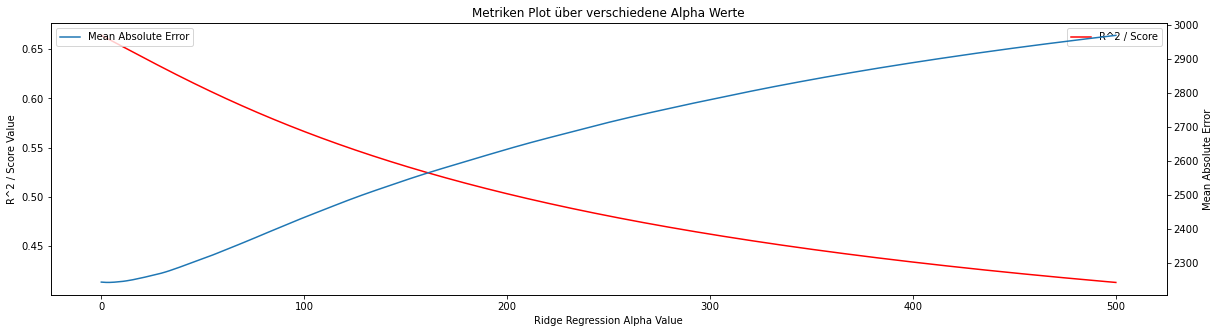

R^2/Score max value: 0.663913429337639
Alpha value for R^2/Score max value: 0.0

Mean Absolute Error min value: 2243.1215957872087
Alpha value for Mean Absolute Error min value: 3.05030503050305

Mean Absolute Error where R^2 is max 2244.13418308853
R^2/Score value where MAE is minimum: 0.6637526598786062


In [9]:
##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 500, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input, train_labels)

    predics = RidgeRegressor.predict(test_input)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

Der Score und der MAE sind bei einem ähnlichen Punkt minimal beziehungsweise maximal. Der MAE ist minimal 2243-2244 und der Score ca. 0.66. Dieser Wert kann man mit dem Standardisieren der Daten, PCA und Logarithmierung verbessern. Die gleiche Auswertung wird auch bei nächsten Plots gemacht.

##### Standardizing data seems to reduce MAE and only marginally decrease the score by 0.02

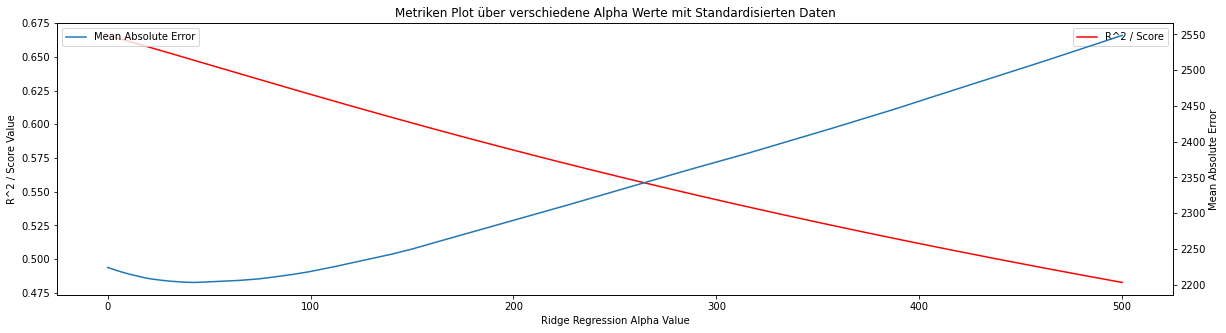

R^2/Score max value: 0.6659357299680028
Alpha value for R^2/Score max value: 0.0

Mean Absolute Error min value: 2203.0901961744653
Alpha value for Mean Absolute Error min value: 42.204220422042205

Mean Absolute Error where R^2 is max 2224.082536935141
R^2/Score value where MAE is minimum: 0.6650535418614276


In [10]:
train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 500, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte mit Standardisierten Daten")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

Mit der Standardisierung wird eine kleine Verbesserung erzielt.

[3.58185088 3.29063819 3.2928695  ... 3.9037892  3.43977686 3.65402918]


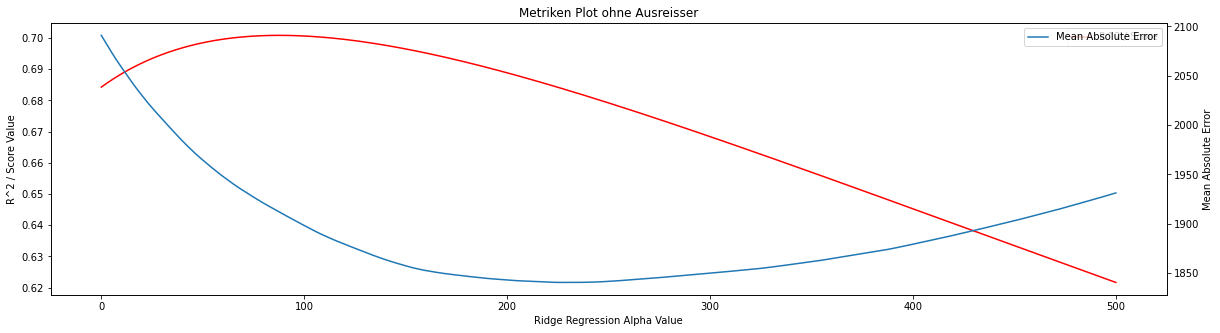

R^2/Score max value: 0.7008229171949505
Alpha value for R^2/Score max value: 87.7087708770877

Mean Absolute Error min value: 1840.5318649743126
Alpha value for Mean Absolute Error min value: 232.6232623262326

Mean Absolute Error where R^2 is max 2076.020052982129
R^2/Score value where MAE is minimum: 0.6891250275073546


In [50]:
labels = np.array(data_no_outliers['charges'])
# The data we want to split = 'input'
input = data_no_outliers.drop('charges', axis=1).drop('charges_level', axis=1).drop('bmi', axis = 1)

# The argument for the split function has to be an array
input_list = list(input.columns)
input = np.array(input)

print(np.log(input[:,5]))

train_input, test_input, train_labels, test_labels = \
    train_test_split(input, labels, test_size = 0.25, random_state = 42) 

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 500, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

Im obigen Code wurden die Daten von den Ausreissern bereinigt. Das Ergebnis sieht viel besser aus. Das Minimum des MAE ist ca. 1534.8. Der Score, wo MAE beim Minimum ist, ist ca. 0.72.

##### What does it look like when we differentiate between smoker and non smoker and do for each one a seperate regression? The following example uses only smokers and the MAE is 1000 but with non smokers the MAE is 3000...

In [12]:
data_smoker = data_no_outliers[data_no_outliers['smoker'] == 1]
data_non_smoker = data_no_outliers[data_no_outliers['smoker'] == 0]
print(type(data_non_smoker), type(data_no_outliers))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


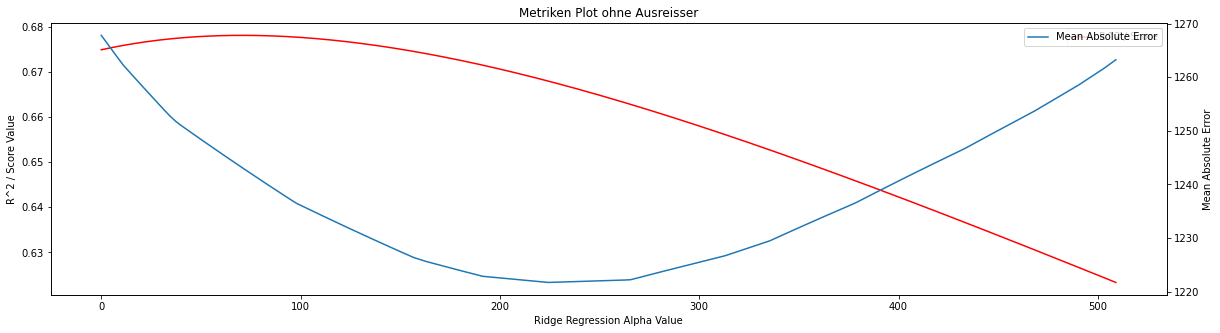

R^2/Score max value: 0.6781040022412468
Alpha value for R^2/Score max value: 70.65626562656266

Mean Absolute Error min value: 1221.7109076394504
Alpha value for Mean Absolute Error min value: 224.28782878287828

Mean Absolute Error where R^2 is max 1265.9636094278776
R^2/Score value where MAE is minimum: 0.6759068005210382


In [20]:
labels = np.array(data_smoker['charges'])
# The data we want to split = 'input'
input = data_smoker.drop('charges', axis=1).drop('charges_level', axis=1).drop('bmi', axis = 1).drop('smoker', axis = 1).drop('sex', axis = 1)

# The argument for the split function has to be an array
input_list = list(input.columns)
input = np.array(input)

train_input, test_input, train_labels, test_labels = \
    train_test_split(input, labels, test_size = 0.1, random_state = 42) 

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

##instantiate regressor
scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 509, 10000)
for i in alphaRange:  
    RidgeRegressor = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)
    
    predics = RidgeRegressor.predict(test_input_standardize)
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

Wenn man zwischen Raucher und Nicht-Raucher bei der Regression unterscheidet, wird der MAE besser für die Raucher, aber für die Nicht-Raucher wird MAE schlechter.

##### Im folgenden Code wurde mit dem Logaritmus der Daten herumgespielt

Der Logarithmus der Charges hat die besten Ergebnisse erzielt. Der durchschnittliche absolute Fehler konnte auf 1073 verringert werden. Logarithmus von anderen Features ergeben schlechtere Resultate.

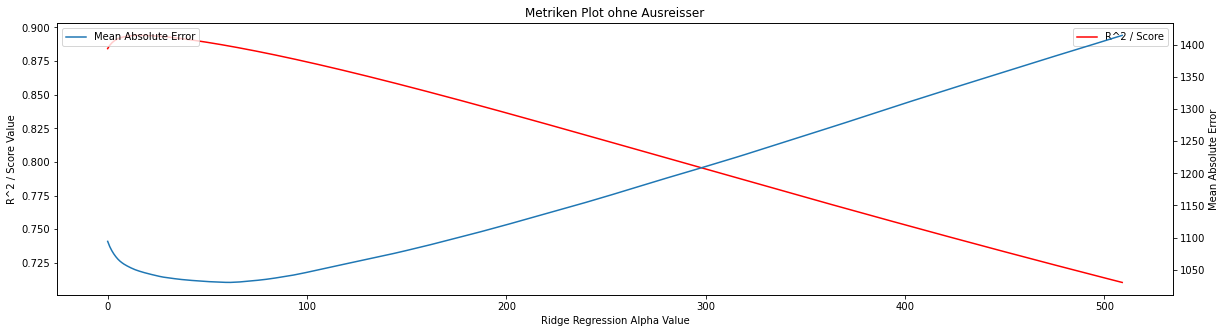

R^2/Score max value: 0.8941493915516623
Alpha value for R^2/Score max value: 16.304304304304303

Mean Absolute Error min value: 1030.2449254030341
Alpha value for Mean Absolute Error min value: 61.141141141141134

Mean Absolute Error where R^2 is max 1058.7990595918857
R^2/Score value where MAE is minimum: 0.8927654659592779


In [22]:
labels = np.array(np.log(data_no_outliers['charges']))
# The data we want to split = 'input'
data_no_outliers_log = data_no_outliers.copy()

input = data_no_outliers_log.drop('charges', axis=1).drop('charges_level', axis=1)

# The argument for the split function has to be an array
input_list = list(input.columns)
input = np.array(input)

alphaRange = np.linspace(0, 509, 1000)

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.25, random_state = 42) 
train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)
##instantiate regressor
scoreArray = []
maeArray = []
for j in alphaRange:  
    RidgeRegressor_log = RidgeRegression(opt_method='neq', alpha = j)
    ridge1 = RidgeRegressor_log.fit(train_input_standardize, train_labels)

    predics = np.exp(RidgeRegressor_log.predict(test_input_standardize))
    score = RidgeRegressor_log.score(np.exp(test_labels), predics)
    mae = RidgeRegressor_log.mae(np.exp(test_labels), predics)
    maeArray.append(mae)
    scoreArray.append(score)

plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

### PCA:

In the following PCA example, sex, bmi and pbf were orthogonalized and in the dataframe that was used for the regression, the orthogonalized versions of those features were used instead of the original ones. Furthermore, to match our marketing strategy, biological sex was dropped all together as a feature, while remaining its orthogonalized principal component. Dropping this feature resulted in a slightly better version of the model. 

[[-0.57735027 -0.57735027 -0.57735027]
 [-0.57533275  0.78940751 -0.21407476]
 [-0.57936076 -0.2085724   0.78793316]]


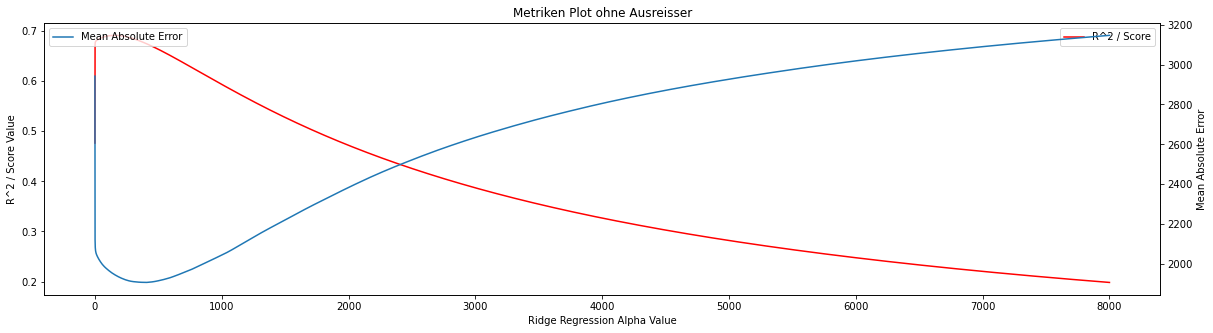

R^2/Score max value: 0.6909598144131222
Alpha value for R^2/Score max value: 154.80774038701935

Mean Absolute Error min value: 1907.8297710904453
Alpha value for Mean Absolute Error min value: 402.42012100605035

Mean Absolute Error where R^2 is max 1995.7065185818203
R^2/Score value where MAE is minimum: 0.6909471396310798


In [47]:
pca_data = data_no_outliers[['sex','bmi', 'pbf']]

X = pca_data.values
X = X.T
x_mean = X - np.mean(X, axis=0) 

test = np.cov(x_mean)
(eigvalues_, components_) = np.linalg.eigh(test)
print(components_.T)
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

data4 = data_no_outliers.copy()
data4[['pc1','pc2', 'pc3']] = np.dot(data4[['sex','bmi', 'pbf']].values, components_.T)

labels = np.array(data_no_outliers['charges'])

# The data we want to split = 'input'
input = data4.drop('sex', axis=1).drop('bmi', axis = 1).drop('pbf', axis = 1).drop('charges', axis = 1).drop('charges_level', axis = 1)

# The argument for the split function has to be an array
input = np.array(input)

alphaRange = np.linspace(0, 8000, 20000)

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.25, random_state = 42) 
train_input = np.array(train_input, dtype=np.float64)
test_input = np.array(test_input, dtype=np.float64)

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

scoreArray = []
maeArray = []

for j in alphaRange:  
    RidgeRegressor_pca = RidgeRegression(opt_method='neq', alpha = j)
    ridge1 = RidgeRegressor_pca.fit(train_input_standardize, train_labels)

    predics = RidgeRegressor_pca.predict(test_input_standardize)
    score = RidgeRegressor_pca.score(test_labels, predics)
    mae = RidgeRegressor_pca.mae(test_labels, predics)
    maeArray.append(mae)
    scoreArray.append(score)

plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot ohne Ausreisser")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

In [48]:
RidgeRegressor = RidgeRegression(opt_method='neq', alpha = 375)
ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

predics = RidgeRegressor.predict(test_input_standardize)

test = test_input_standardize
print("Input Data: ", test[10:16:])
print("Real Charges: ", test_labels[10:16:])
print("Predicted Charges: ", predics[10:16:])

Input Data:  [[-8.74359419e-01  6.56987288e-01 -2.09453975e+00 -1.29467610e+00
   2.85479638e-01  8.55996396e-01 -6.65498730e-01]
 [ 3.28308406e-01  6.56987288e-01  4.77431855e-01  1.44217085e+00
  -1.37473149e+00  2.42326601e-02  1.45971664e+00]
 [-4.49888422e-01 -1.29513623e-01 -2.09453975e+00  1.44217085e+00
   8.05437628e-02  8.46966795e-01 -4.59949121e-01]
 [-1.36957558e+00 -1.29513623e-01  4.77431855e-01  5.29888532e-01
   1.46336748e+00 -3.80954261e-04 -1.54527368e+00]
 [-3.79143256e-01  3.01649002e+00  4.77431855e-01 -1.29467610e+00
  -1.24961066e+00  1.95118909e+00  4.88010497e-01]
 [-6.62123921e-01 -9.16014534e-01 -2.09453975e+00 -1.29467610e+00
  -7.24019392e-02  9.05175905e-01 -3.28114753e-01]]
Real Charges:  [ 6556  7737 10859  2298  7658  9845]
Predicted Charges:  [10264.02858725  9406.19009541 11917.44410864   713.46011764
  9425.80459992 11138.68474846]


PCA von anderen features ist nicht gut.

[[ 0.5         0.5         0.5         0.5       ]
 [ 0.00977969 -0.5930085  -0.19734742  0.78057624]
 [ 0.26404285 -0.62373651  0.66797815 -0.30828449]
 [-0.82473373  0.09640371  0.51464472  0.2136853 ]]


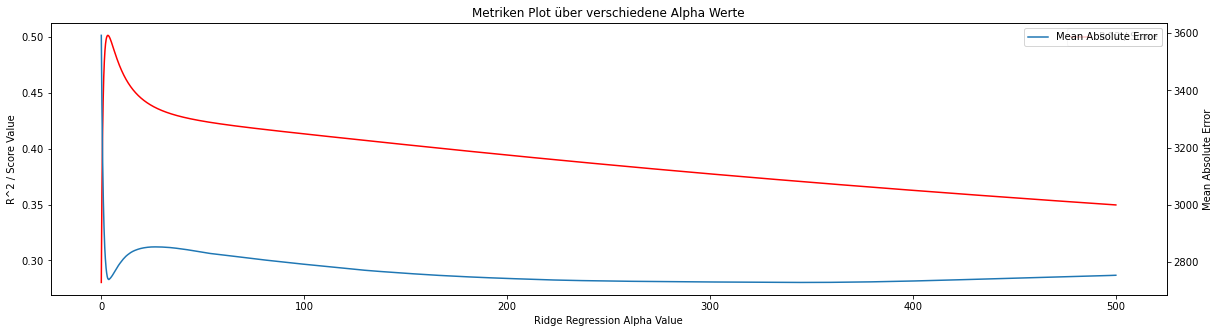

R^2/Score max value: 0.5012581575758335
Alpha value for R^2/Score max value: 3.25032503250325

Mean Absolute Error min value: 2728.5830783482397
Alpha value for Mean Absolute Error min value: 348.1348134813481

Mean Absolute Error where R^2 is max 3461.907764118041
R^2/Score value where MAE is minimum: 0.4489488802090056


In [49]:
pca_data = data_no_outliers[['age','smoker', 'pbf', 'bmi']]

X = pca_data.values
X = X.T
x_mean = X - np.mean(X, axis=0) 

test = np.cov(x_mean)
(eigvalues_, components_) = np.linalg.eigh(test)
print(components_.T)
idx = eigvalues_.argsort()[::-1]   
eigvalues_ = eigvalues_[idx]
total_variance_ = np.sum(eigvalues_)
explained_variance_ = eigvalues_ / total_variance_

data4 = data_no_outliers.copy()
data4[['pc1','pc2', 'pc3', 'pc4']] = np.dot(data4[['age','smoker', 'pbf', 'bmi']].values, components_.T)

labels = np.array(data_no_outliers['charges'])

# The data we want to split = 'input'
input = data4.drop('sex', axis=1).drop('age', axis=1).drop('smoker', axis=1).drop('pbf', axis=1).drop('bmi', axis=1).drop('charges', axis = 1).drop('charges_level', axis = 1)

# The argument for the split function has to be an array
input = np.array(input)

alphaRange = np.linspace(0, 8000, 20000)

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.25, random_state = 42) 
train_input = np.array(train_input, dtype=np.float64)
test_input = np.array(test_input, dtype=np.float64)

train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

scoreArray = []
maeArray = []

alphaRange = np.linspace(0, 500, 10000)
for i in alphaRange:  
    RidgeRegressor_pca2 = RidgeRegression(opt_method='neq', alpha = i)
    ridge1 = RidgeRegressor_pca2.fit(train_input_standardize, train_labels)
    predics = RidgeRegressor_pca2.predict(test_input_standardize)
    
    #print(predics[:20])
    bins = [0, 5000, 10000, 20000, 100000]
    predics_categorized = pd.cut(abs(predics), bins=bins, labels=bin_labels, include_lowest=True)
    test_labels_categorized = pd.cut(abs(test_labels), bins=bins, labels=bin_labels, include_lowest=True)
    
    
    #print(predics_categorized.to_numpy(), test_labels_categorized.to_numpy())
    
    score = RidgeRegressor.score(test_labels, predics)
    mae = RidgeRegressor.mae(test_labels, predics)
    #score = RidgeRegressor.score(test_labels_categorized.to_numpy(), predics_categorized.to_numpy())
    #mae = RidgeRegressor.mae(test_labels_categorized.to_numpy(), predics_categorized.to_numpy())
    maeArray.append(mae)
    scoreArray.append(score)


plt.rcParams["figure.figsize"] = (20,5)  

fig1, ax1 = plt.subplots() # two axes on figure
ax1.plot(alphaRange, scoreArray, label="R^2 / Score", color = "r")
ax1.set_xlabel("Ridge Regression Alpha Value")
ax1.set_ylabel("R^2 / Score Value")
plt.legend()

ax2 = ax1.twinx()
ax2.plot(alphaRange, maeArray, label="Mean Absolute Error")
ax2.set_xlabel("Ridge Regression Alpha Value")
ax2.set_ylabel("Mean Absolute Error")

plt.title("Metriken Plot über verschiedene Alpha Werte")
plt.legend()
plt.show()

print("R^2/Score max value:", np.amax(scoreArray))
print("Alpha value for R^2/Score max value:", alphaRange[np.where(scoreArray == np.amax(scoreArray))][0])
print("")
print("Mean Absolute Error min value:", np.amin(maeArray))
print("Alpha value for Mean Absolute Error min value:", alphaRange[np.where(maeArray == np.amin(maeArray))][0])
print("")
print("Mean Absolute Error where R^2 is max", maeArray[alphaRange[np.where(scoreArray == np.amax(scoreArray))][0].round(decimals=0).astype(np.int64)])
print("R^2/Score value where MAE is minimum:", scoreArray[alphaRange[np.where(maeArray == np.amin(maeArray))][0].round(decimals=0).astype(np.int64)])

In [19]:
# YOUR CODE HERE
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sn

Die folgende Confusion Matrix zeigt das Resultat der Ridge Regressiond es besten Modells(log von Charges). Die einzelnen Predictions werden in die Kategorien eingeteilt und es wird geschaut, ob diese Kategorie der wahren kategorie entspricht.

In [73]:
labels = np.array(np.log(data_no_outliers['charges']))
# The data we want to split = 'input'
data_no_outliers_log = data_no_outliers.copy()

input = data_no_outliers_log.drop('charges', axis=1).drop('charges_level', axis=1)
input = np.array(input)

alphaRange = np.linspace(0, 509, 1000)

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.25, random_state = 42) 
train_input_standardize = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)
test_input_standardize = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

RidgeRegressor = RidgeRegression(opt_method='neq', alpha = 52.988988988988986)
ridge1 = RidgeRegressor.fit(train_input_standardize, train_labels)

predics = RidgeRegressor.predict(test_input_standardize)

bins = [0, 10000, 29000, 100000]
bins_labels = [0,1,2]

predics_categorized = pd.cut(np.exp(abs(predics)), bins=bins, labels=bin_labels, include_lowest=True)
test_labels_categorized = pd.cut(np.exp(abs(test_labels)), bins=bins, labels=bin_labels, include_lowest=True)


cm = confusion_matrix(predics_categorized, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

#logistic_regression.score(X_test, y_test)
#plot_confusion_matrix(logistic_regression, X_test, y_test, display_labels = y_labels)
print(classification_report(test_labels_categorized, predics_categorized))

ValueError: Bin labels must be one fewer than the number of bin edges

#### Logistic Regression:

C:\Users\bruno\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


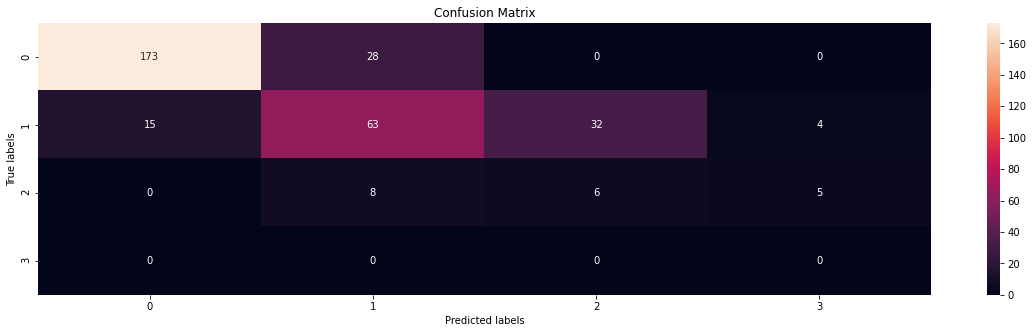

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       188
           1       0.55      0.64      0.59        99
           2       0.32      0.16      0.21        38
           3       0.00      0.00      0.00         9

    accuracy                           0.72       334
   macro avg       0.43      0.43      0.42       334
weighted avg       0.68      0.72      0.70       334



C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\bruno\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
labels = np.array(np.log(data_no_outliers['charges']))
# The data we want to split = 'input'
data_no_outliers_log = data_no_outliers.copy()

input = data_no_outliers_log.drop('charges', axis=1).drop('charges_level', axis=1)
input = np.array(input)

alphaRange = np.linspace(0, 509, 1000)

train_input, test_input, train_labels, test_labels = \
train_test_split(input, labels, test_size = 0.25, random_state = 42) 

scaler = preprocessing.StandardScaler().fit(train_input)
X_scaled = scaler.transform(train_input)

logistic_regression = LogisticRegression(max_iter = 100)
test_labels_categorized = pd.cut(np.exp(test_labels), bins=bins, labels=bin_labels, include_lowest=True)
train_labels_categorized = pd.cut(np.exp(train_labels), bins=bins, labels=bin_labels, include_lowest=True)

logistic_regression.fit(train_input, train_labels_categorized)
label_prediction = logistic_regression.predict(test_input)

cm = confusion_matrix(label_prediction, test_labels_categorized)

ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
plt.show()

print(classification_report(test_labels_categorized, label_prediction))

## TODO?

- Backwards/Forwards Selection
- ✓ (for alpha) Metrics
- Check factorization?
- ✓ (just the children outliers and the extremely high bmi for 20 years odl) Check outliers
- ✓ Logarithms?
- ✓ (For the biggest influencer of charges) Orthogonalization using PCA?
- Polynomials?
- Se
- ✓ (For smoker it's much more accurate) Aufteilung in mehrere regression pro raucherklassen

After first deep dive TODO:
- PCA for more split up categories like in example for smokers